# Yolo V8 + SAM



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
!pip install ultralytics==8.1.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 699.2/699.2 kB 6.7 MB/s eta 0:00:00
  Attempting uninstall: ultralytics
    Found existing installation: ultralytics 8.0.81
    Uninstalling ultralytics-8.0.81:
      Successfully uninstalled ultralytics-8.0.81
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autodistill-yolov8 0.1.4 requires ultralytics==8.0.81, but you have ultralytics 8.1.0 which is incompatible.


In [1]:
!pip install segment_anything

In [2]:
import ultralytics
from ultralytics import YOLO
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from IPython.display import display, Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
ultralytics.checks()

Ultralytics YOLOv8.1.0 🚀 Python-3.10.12 torch-2.1.0+cu121 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.5/225.8 GB disk)


In [5]:
!pip install -q \
autodistill \
autodistill-grounded-sam \
autodistill-yolov8 \
roboflow \
supervision==0.9.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.9/69.9 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.4/82.4 kB 10.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.0/527.0 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.5/257.5 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.7/254.7 kB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 68.9 M

# Autodistll for labelling

In [ ]:
# Original Path for the dataset
data_path = "/content/drive/MyDrive/veg_dataset/Vegetable Images/train/Tomato/"
# Path for Saving our Labelled Images
destination_DIR_PATH = f"/content/drive/MyDrive/labelled_veg/"

# Setting Ontology
from autodistill.detection import CaptionOntology

ontology = CaptionOntology({
    "tomato": "tomato"
})

In [ ]:
from autodistill_grounded_sam import GroundedSAM

# Initializing the GroundedSAM model
base_model = GroundedSAM(ontology=ontology)
dataset = base_model.label(
    input_folder = data_path,
    extension = "jpg",
    output_folder = destination_DIR_PATH )

trying to load grounding dino directly
final text_encoder_type: bert-base-uncased


Labeling /content/drive/MyDrive/veg_dataset/Vegetable Images/train/Tomato/0001.jpg:   0%|          | 0/1000 [00:00<?, ?it/s]The `device` argument is deprecated and will be removed in v5 of Transformers.
torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
None of the inputs have requires_grad=True. Gradients will be None
Labeling /content/drive/MyDrive/veg_dataset/Vegetable Images/train/Tomato/0002.jpg:   0%|          | 1/1000 [00:13<3:51:29, 13.90s/it]The `device` argument is deprecated and will be removed in v5 of Transformers.
torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the 

Labeled dataset created - ready for distillation.


In [ ]:
# Data and Annotations Path
ANNOTATIONS_DIRECTORY_PATH = "/content/drive/MyDrive/labelled_veg/train/labels"
IMAGES_DIRECTORY_PATH = "/content/drive/MyDrive/labelled_veg/train/images"
DATA_YAML_PATH = "/content/drive/MyDrive/labelled_veg/data.yaml"

In [ ]:
import supervision as sv

dataset = sv.DetectionDataset.from_yolo(
    images_directory_path=IMAGES_DIRECTORY_PATH,
    annotations_directory_path=ANNOTATIONS_DIRECTORY_PATH,
    data_yaml_path=DATA_YAML_PATH)

len(dataset)

800

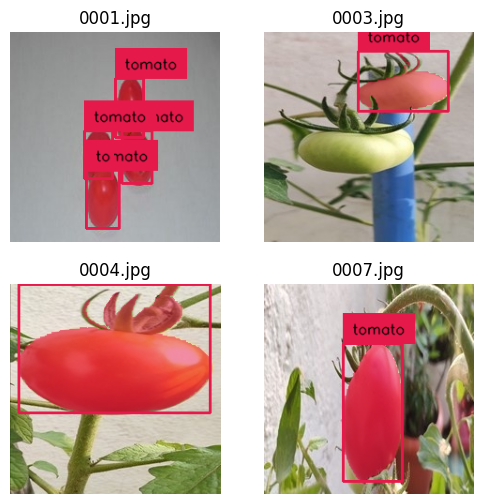

In [ ]:
SAMPLE_SIZE = 4
SAMPLE_GRID_SIZE = (2, 2)
SAMPLE_PLOT_SIZE = (6, 6)

image_names = list(dataset.images.keys())[:SAMPLE_SIZE]

mask_annotator = sv.MaskAnnotator()
box_annotator = sv.BoxAnnotator()

images = []
for image_name in image_names:
    image = dataset.images[image_name]
    annotations = dataset.annotations[image_name]
    labels = [
        dataset.classes[class_id]
        for class_id
        in annotations.class_id]
    annotates_image = mask_annotator.annotate(
        scene=image.copy(),
        detections=annotations)
    annotates_image = box_annotator.annotate(
        scene=annotates_image,
        detections=annotations,
        labels=labels)
    images.append(annotates_image)

sv.plot_images_grid(
    images=images,
    titles=image_names,
    grid_size=SAMPLE_GRID_SIZE,
    size=SAMPLE_PLOT_SIZE)

# Train the YOLOv8 Model on Images

In [4]:
file_path = "/content/drive/MyDrive/veg_dataset/Vegetable Images/test/Tomato/1001.jpg"

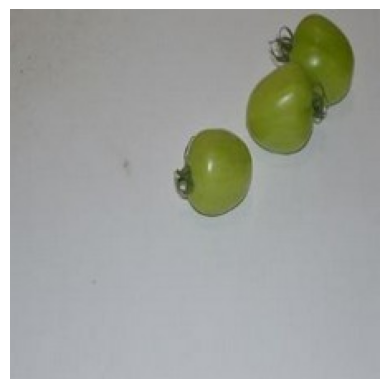

In [5]:
from PIL import Image
from ultralytics import YOLO

image = Image.open(file_path)
plt.imshow(image)
plt.axis('off')
plt.show()

In [41]:
from autodistill_yolov8 import YOLOv8

target_model = YOLOv8("yolov8n.pt")
target_model.train(DATA_YAML_PATH, epochs=50)

In [10]:
# Predict the Random Tomato Image
!yolo predict model="/content/drive/MyDrive/tomatoe_weights/best.pt" source = "/content/drive/MyDrive/veg_dataset/Vegetable Images/test/Tomato/1001.jpg"

WARNING ⚠️ Ultralytics settings reset to defaults. This is normal and may be due to a recent ultralytics package update, but may have overwritten previous settings. 
View and update settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.yaml'
2024-01-31 23:24:27.197265: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-31 23:24:27.197337: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-31 23:24:27.199532: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Ultralytics YOLOv8.0.81 🚀 Python-3.10.12 torch-2.1.0+cu121 CPU
Model summary (fused): 168 layers, 3005843

In [6]:
# Load the Saved trained Model
model = YOLO('/content/drive/MyDrive/tomatoe_weights/best.pt')
results = model.predict(file_path)
# Extract the bounding boxes from the image
boxes = results[0].boxes.xyxy


image 1/1 /content/drive/MyDrive/veg_dataset/Vegetable Images/test/Tomato/1001.jpg: 640x640 3 tomatos, 635.5ms
Speed: 35.8ms preprocess, 635.5ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


In [7]:
boxes

tensor([[143.2208,  32.6234, 182.8410,  86.5857],
        [100.1986,  72.6320, 145.7690, 124.4035],
        [159.8270,   2.9951, 207.4332,  65.1524]])

# Segment Anything Model

In [ ]:
# Install the necessary Library files from the github
!pip install ultralytics
!pip install 'git+https://github.com/facebookresearch/segment-anything.git'
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-_wb9paxf
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-_wb9paxf
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36587 sha256=328b68da513137a4741bf737e1b47417205933f2703f78c273c54ad9ba1b95f8
  Stored in directory: /tmp/pip-ephem-wheel-cache-ub4n3k1i/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything


--2024-01-15 21:48:32--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.19, 3.162.163.51, 3.162.163.34, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   241MB/s    in 14s     

2024-01-15 21:48:46 (181 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



In [ ]:
import torch
# Define the Model type and checkpoint
sam_checkpoint = "/content/sam_vit_h_4b8939.pth"
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint).to(device=torch.device('cuda'))

In [ ]:
# Read the Image and convert to the color image
image = cv2.cvtColor(cv2.imread(file_path ) , cv2.COLOR_BGR2RGB )

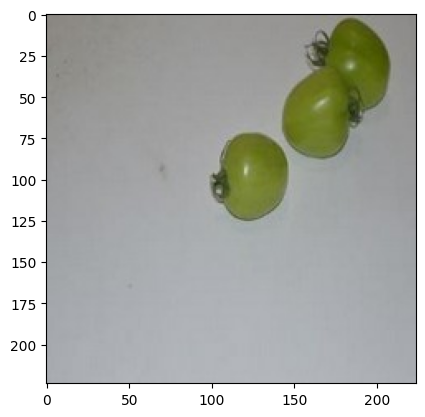

In [ ]:
plt.imshow(image)
plt.show()

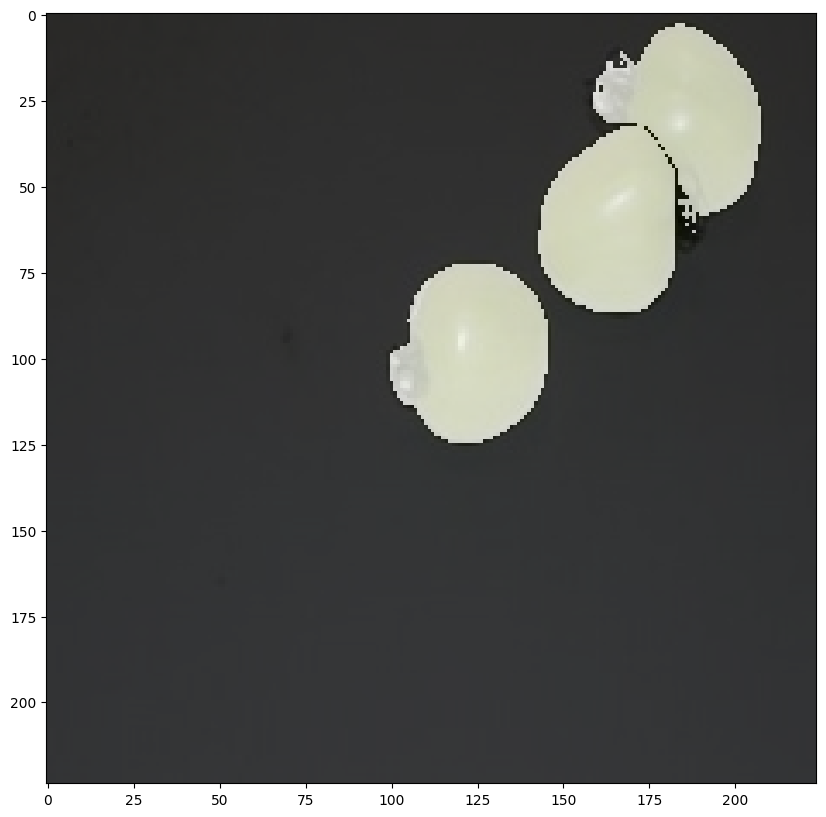

In [ ]:
# Intiate the Predictor Class
mask_predictor = SamPredictor(sam)

# Transform the YOLOv8 predicted boxes to match input format expected by SAM model
transformed_boxes = mask_predictor.transform.apply_boxes_torch(boxes, image.shape[:2])

# Run SAM model on all the boxes
mask_predictor.set_image(image)
masks, _, _ = mask_predictor.predict_torch(
   boxes = transformed_boxes,
   multimask_output=False,
   point_coords=None,
   point_labels=None
)

# combine all masks into one for easy visualization
masks = masks.cpu()
final_mask = None
for i in range(len(masks) - 1):
  if final_mask is None:
    final_mask = np.bitwise_or(masks[i][0], masks[i+1][0])
  else:
    final_mask = np.bitwise_or(final_mask, masks[i+1][0])

# visualize the predicted masks
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.imshow(final_mask, cmap='gray', alpha=0.7)
plt.show()